<a href="https://colab.research.google.com/github/ismailasy/Deep_IOT_Network_Anomaly_Detection/blob/main/Memoire_Classification_binaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install  bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=0e6b3f9247be4492cb1de2a9a8469981a37b042280a1b39e934a4640cc0e1fd9
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from bayes_opt import BayesianOptimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D,LSTM, MaxPooling2D,UpSampling2D,Conv2DTranspose, Dropout, Flatten, Activation, LeakyReLU, ReLU, Input,concatenate,BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D,LSTM, MaxPooling2D,UpSampling2D,Conv2DTranspose, Dropout, Flatten, Activation, LeakyReLU, ReLU, Input,concatenate,BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import files 
  
  
uploaded = files.upload()

Saving UNSW_NB15_testing.csv to UNSW_NB15_testing.csv
Saving UNSW_NB15_training.csv to UNSW_NB15_training.csv


In [51]:
import pandas as pd 
import io 
  
df_train = pd.read_csv(io.BytesIO(uploaded['UNSW_NB15_training.csv']))  
df_test =  pd.read_csv(io.BytesIO(uploaded['UNSW_NB15_testing.csv']))  

In [52]:
#supprimer les colonnes inutiles
df_train.drop('id', axis=1, inplace=True)
df_train.drop('attack_cat', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)
df_test.drop('attack_cat', axis=1, inplace=True)

In [53]:
#Nous concaténons l'ensemble d'apprentissage et l'ensemble de test pour manipuler directement l'ensemble.
df = pd.concat([df_train,df_test],axis=0)

In [54]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0


In [55]:
df.shape

(257673, 43)

In [56]:
df_class_Normal = df[df['label'] == 0]
df_class_Attack = df[df['label'] == 1]


In [57]:
#Sous-échantillonnage de la catégorie d'attaque jusqu'à atteindre la même valeur que la catégorie Normal
df_class_Attack = df_class_Attack.sample(df_class_Normal.shape[0])
#Concaténé
df = pd.concat([df_class_Normal,df_class_Attack], axis=0)

In [58]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0


Forme de dataFrame: (186000, 43) 

Nombre d'échantillons d'attaque


0    93000
1    93000
Name: label, dtype: int64


Tracer l'équilibre de dataFrame


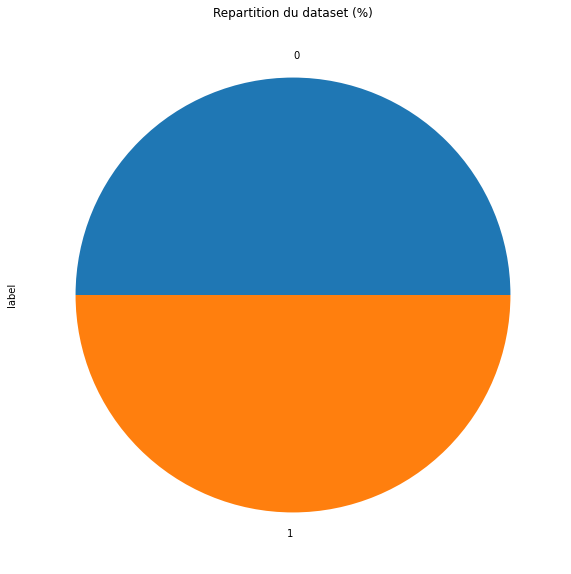

In [59]:
#Visualisation dans un graphique circulaire du poids de chaque classe
print("Forme de dataFrame: {} \n".format(df.shape))
print("Nombre d'échantillons d'attaque")
display(df['label'].value_counts())
print("")
print("Tracer l'équilibre de dataFrame")
df_plot = (df['label'].value_counts(normalize=True) *100)
df_plot.plot(kind='pie',figsize=(10,10),title='Repartition du dataset (%)')

In [60]:
#Conversion de la chaîne de type de données en nombres entiers dans une plage comprise entre 0 et 255 (1 octet d'informations)
def encode_string_byte (df,name):
  df[name] = LabelEncoder().fit_transform(df[name])

encode_string_byte (df,'proto')
encode_string_byte (df,'state') 
encode_string_byte (df,'service') 

In [61]:
#Normalisation des nombres entiers en valeurs décimales comprises entre 0 et 1
def numerical_minmax_normalization (df, name):
  x = df[name].values.reshape(-1,1)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df[name] = x_scaled

numerical_minmax_normalization(df,'dur')
numerical_minmax_normalization(df,'spkts')
numerical_minmax_normalization(df,'dpkts')
numerical_minmax_normalization(df,'sbytes')
numerical_minmax_normalization(df,'dbytes')
numerical_minmax_normalization(df,'rate')
numerical_minmax_normalization(df,'sttl')
numerical_minmax_normalization(df,'dttl')
numerical_minmax_normalization(df,'sload')
numerical_minmax_normalization(df,'dload')
numerical_minmax_normalization(df,'sloss')
numerical_minmax_normalization(df,'dloss')
numerical_minmax_normalization(df,'sinpkt')
numerical_minmax_normalization(df,'dinpkt')
numerical_minmax_normalization(df,'sjit')
numerical_minmax_normalization(df,'djit')
numerical_minmax_normalization(df,'swin')
numerical_minmax_normalization(df,'stcpb')
numerical_minmax_normalization(df,'dtcpb')
numerical_minmax_normalization(df,'dwin')
numerical_minmax_normalization(df,'tcprtt')
numerical_minmax_normalization(df,'synack')
numerical_minmax_normalization(df,'ackdat')
numerical_minmax_normalization(df,'smean')
numerical_minmax_normalization(df,'dmean')
numerical_minmax_normalization(df,'trans_depth')
numerical_minmax_normalization(df,'response_body_len')
numerical_minmax_normalization(df,'ct_srv_src')
numerical_minmax_normalization(df,'ct_state_ttl')
numerical_minmax_normalization(df,'ct_dst_ltm')
numerical_minmax_normalization(df,'ct_src_dport_ltm')
numerical_minmax_normalization(df,'ct_dst_sport_ltm')
numerical_minmax_normalization(df,'ct_dst_src_ltm')
numerical_minmax_normalization(df,'is_ftp_login')
numerical_minmax_normalization(df,'ct_ftp_cmd')
numerical_minmax_normalization(df,'ct_flw_http_mthd')
numerical_minmax_normalization(df,'ct_src_ltm')
numerical_minmax_normalization(df,'ct_srv_dst')
numerical_minmax_normalization(df,'is_sm_ips_ports')

In [62]:
#Mappage des valeurs normalisées de l'étape précédente sur des valeurs entières comprises entre 0 et 255 (1 Byte d'information)
def numerical_split_ohe (df,name):
  pd_to_np = df[name].tolist()
  np_split = []
  
  categories = np.linspace(0, 1, num=256,endpoint=False)
  quantization = range(0,256)

  for value in pd_to_np:
    for i in range(len(categories)-1):
      if (categories[i] <= float(value) <= categories[i+1]):
        np_split.append(quantization[i])
        break
      if (float(value) > categories[-1]):
        np_split.append(quantization[-1])
        break
  
  df[name] = np_split


numerical_split_ohe(df,'dur')
numerical_split_ohe(df,'spkts')
numerical_split_ohe(df,'dpkts')
numerical_split_ohe(df,'sbytes')
numerical_split_ohe(df,'dbytes')
numerical_split_ohe(df,'rate')
numerical_split_ohe(df,'sttl')
numerical_split_ohe(df,'dttl')
numerical_split_ohe(df,'sload')
numerical_split_ohe(df,'dload')
numerical_split_ohe(df,'sloss')
numerical_split_ohe(df,'dloss')
numerical_split_ohe(df,'sinpkt')
numerical_split_ohe(df,'dinpkt')
numerical_split_ohe(df,'sjit')
numerical_split_ohe(df,'djit')
numerical_split_ohe(df,'swin')
numerical_split_ohe(df,'stcpb')
numerical_split_ohe(df,'dtcpb')
numerical_split_ohe(df,'dwin')
numerical_split_ohe(df,'tcprtt')
numerical_split_ohe(df,'synack')
numerical_split_ohe(df,'ackdat')
numerical_split_ohe(df,'smean')
numerical_split_ohe(df,'dmean')
numerical_split_ohe(df,'trans_depth')
numerical_split_ohe(df,'response_body_len')
numerical_split_ohe(df,'ct_srv_src')
numerical_split_ohe(df,'ct_state_ttl')
numerical_split_ohe(df,'ct_dst_ltm')
numerical_split_ohe(df,'ct_src_dport_ltm')
numerical_split_ohe(df,'ct_dst_sport_ltm')
numerical_split_ohe(df,'ct_dst_src_ltm')
numerical_split_ohe(df,'is_ftp_login')
numerical_split_ohe(df,'ct_ftp_cmd')
numerical_split_ohe(df,'ct_flw_http_mthd')
numerical_split_ohe(df,'ct_src_ltm')
numerical_split_ohe(df,'ct_srv_dst')
numerical_split_ohe(df,'is_sm_ips_ports')

In [63]:
#Retirer la colonne attack_cat et l'enregistrer dans la variable y.
y_column = df['label']
df.drop('label',axis=1,inplace=True)
dummies = pd.get_dummies(y_column) 
y = dummies.values

In [64]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [65]:
#Normalisation des valeurs entre -0.5 et 0.5
x = []
for image in np.array(df.to_numpy()):
  x.append((image/255 - 0.5))
x = np.array(x)

In [66]:
x

array([[-0.5       , -0.05686275, -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.49215686, -0.05686275, -0.5       , ..., -0.5       ,
        -0.42156863, -0.5       ],
       [-0.47647059, -0.05686275, -0.5       , ..., -0.48431373,
        -0.42156863, -0.5       ],
       ...,
       [-0.49215686, -0.05686275, -0.5       , ..., -0.48431373,
        -0.5       , -0.5       ],
       [-0.5       , -0.05686275, -0.48039216, ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.5       , -0.02941176, -0.5       , ..., -0.46862745,
        -0.46862745, -0.5       ]])

In [67]:
x.shape

(186000, 42)

In [68]:
#Séparation du jeu de données en un ensemble d'apprentissage et un ensemble de validation.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(x,y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [69]:
y_train

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [70]:
y_test

array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

In [19]:
x_train.shape[1]

42

In [71]:
# Modele LSTM
#Mise en place du modele LSTM a 5 couches
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model_lstm = Sequential() 
model_lstm.add(LSTM(units = 512, return_sequences = True, input_shape = (x_train.shape[1],1), activation='tanh'))
#model_lstm.add(LSTM(units = 512, return_sequences = True))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(128, activation='relu'))
#model_lstm.add(Dropout(0.2))
#model_lstm.add(Dense(32, activation='relu'))
#model_lstm.add(Dropout(0.2))
#model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Flatten())
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics=['accuracy'] )
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 42, 512)           1052672   
                                                                 
 dense_4 (Dense)             (None, 42, 128)           65664     
                                                                 
 dense_5 (Dense)             (None, 42, 128)           16512     
                                                                 
 flatten_2 (Flatten)         (None, 5376)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 10754     
                                                                 
Total params: 1,145,602
Trainable params: 1,145,602
Non-trainable params: 0
_________________________________________________________________


In [72]:
#processus de formation du modele LSTM
history_lstm = model_lstm.fit(
    x_train,
    y_train,
    validation_split = 0.1,
    epochs = 100,
    batch_size = 256
)

Epoch 1/100
491/491 [==============================] - 17s 29ms/step - loss: 0.3373 - accuracy: 0.8271 - val_loss: 0.3041 - val_accuracy: 0.8434
Epoch 2/100
491/491 [==============================] - 14s 29ms/step - loss: 0.2626 - accuracy: 0.8710 - val_loss: 0.2626 - val_accuracy: 0.8870
Epoch 3/100
491/491 [==============================] - 14s 29ms/step - loss: 0.2340 - accuracy: 0.8887 - val_loss: 0.2307 - val_accuracy: 0.8994
Epoch 4/100
491/491 [==============================] - 14s 29ms/step - loss: 0.2085 - accuracy: 0.9027 - val_loss: 0.2028 - val_accuracy: 0.9067
Epoch 5/100
491/491 [==============================] - 14s 29ms/step - loss: 0.1903 - accuracy: 0.9110 - val_loss: 0.1895 - val_accuracy: 0.9150
Epoch 6/100
491/491 [==============================] - 15s 30ms/step - loss: 0.1827 - accuracy: 0.9154 - val_loss: 0.1870 - val_accuracy: 0.9110
Epoch 7/100
491/491 [==============================] - 15s 30ms/step - loss: 0.1759 - accuracy: 0.9182 - val_loss: 0.1739 - val_ac

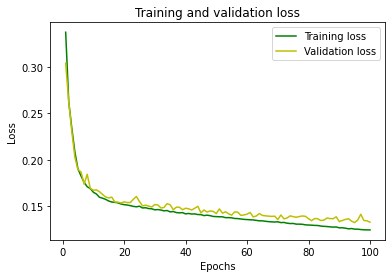

In [73]:
plt.clf()
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

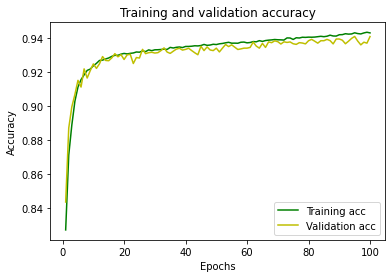

In [74]:
plt.clf()
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [75]:
# Evaluation du model
model_lstm.evaluate(x_test,y_test)

1454/1454 [==============================] - 8s 5ms/step - loss: 0.1322 - accuracy: 0.9398


[0.1321829855442047, 0.9398494362831116]

In [77]:
# Prediction et affichage des performance du model
y_pred = model_lstm.predict(x)
y_pred = np.argmax(y_pred,axis=1) 
y_true = np.argmax(y,axis=1)

print("Accuracy: {}" .format(metrics.accuracy_score(y_true, y_pred)))
print("Precision: {}" .format(metrics.precision_score(y_true, y_pred, average='macro')))
print("Recall: {}" .format(metrics.recall_score(y_true, y_pred, average='macro')))
print("F1: {}" .format(metrics.f1_score(y_true, y_pred, average='macro')))


Accuracy: 0.943231182795699
Precision: 0.9437431769979299
Recall: 0.943231182795699
F1: 0.9432148029992626


In [ ]:
y_test.shape

(46500, 2)

In [ ]:
y_pred.shape

(186000,)

In [79]:
def plot_confusing_matrix (y_compare,pred,n_categories):

  cm = metrics.confusion_matrix(y_compare, pred)
  plot_confusion_matrix(conf_mat=cm,figsize=(13,13),show_normed=True)
  plt.title('Matrice de confusion')
  plt.ylabel('Cible')
  plt.xlabel('Prédite')
  plt.show()

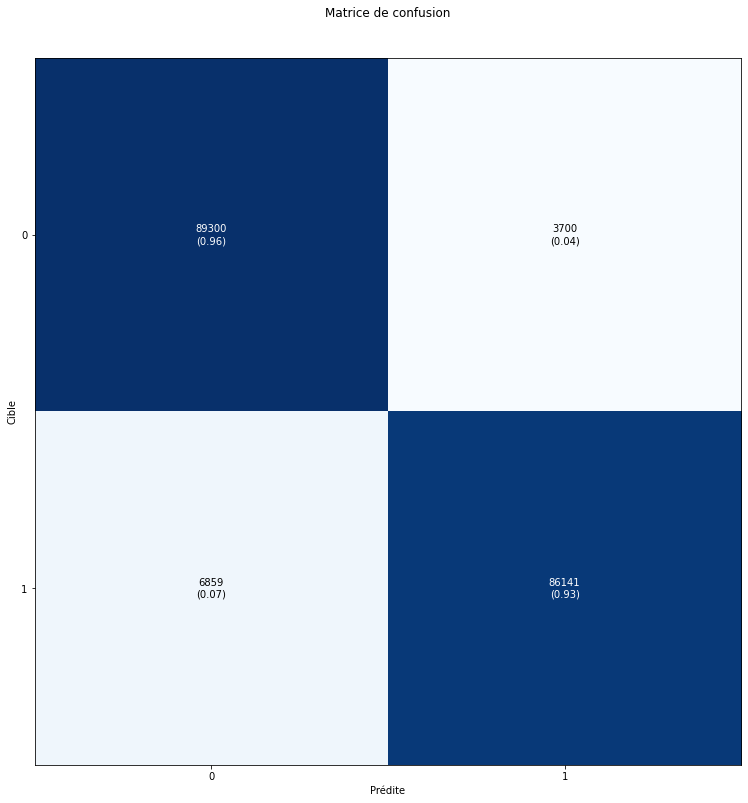

In [80]:
plot_confusing_matrix(y_true,y_pred,2)

Application d'un reseau de neuronnes convolutif


In [81]:

X_train = x_train.reshape(x_train.shape[0], 1, 42, 1)   
X_test= x_test.reshape(x_test.shape[0], 1, 42, 1)

In [35]:
X_test.shape

(46500, 1, 42, 1)

In [36]:
X_train.shape

(139500, 1, 42, 1)

In [38]:
y_train.shape

(139500, 2)

In [39]:
y_test.shape

(46500, 2)

46500

In [43]:
# Model CNN
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, MaxPooling2D,BatchNormalization
from keras.layers import LSTM,TimeDistributed,Conv1D,MaxPooling1D
from keras.layers import Dense, Dropout, Flatten
from keras import models
from keras import layers
from keras.models import Model

CNN_model = Sequential()
CNN_model.add(Conv2D(512, kernel_size=(3, 3),activation='tanh',padding='same',input_shape=(1,42,1)))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
CNN_model.add(Conv2D(256, (3, 3), activation='tanh',padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
CNN_model.add(Conv2D(128, (3, 3), activation='tanh',padding='same'))
CNN_model.add(Conv2D(128, (3, 3), activation='tanh',padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
CNN_model.add(Conv2D(64, (3, 3), activation='tanh',padding='same'))
CNN_model.add(Conv2D(64, (3, 3), activation='tanh',padding='same')) 
CNN_model.add(Conv2D(64, (3, 3), activation='tanh',padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
CNN_model.add(Flatten())
CNN_model.add(Dense(2, activation='softmax'))
CNN_model.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['accuracy'])
CNN_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 1, 42, 512)        5120      
                                                                 
 batch_normalization_7 (Batc  (None, 1, 42, 512)       2048      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 21, 512)       0         
 )                                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 21, 256)        1179904   
                                                                 
 batch_normalization_8 (Batc  (None, 1, 21, 256)       1024      
 hNormalization)                                                 
                                                      

In [44]:
history = CNN_model.fit(X_train,y_train,validation_data=(X_test,y_test),verbose=1,batch_size=512,epochs=200)

Epoch 1/200
273/273 [==============================] - 30s 55ms/step - loss: 0.2319 - accuracy: 0.8918 - val_loss: 0.5300 - val_accuracy: 0.7838
Epoch 2/200
273/273 [==============================] - 13s 49ms/step - loss: 0.1805 - accuracy: 0.9162 - val_loss: 0.2388 - val_accuracy: 0.8739
Epoch 3/200
273/273 [==============================] - 14s 50ms/step - loss: 0.1706 - accuracy: 0.9206 - val_loss: 0.1847 - val_accuracy: 0.9098
Epoch 4/200
273/273 [==============================] - 14s 50ms/step - loss: 0.1632 - accuracy: 0.9240 - val_loss: 0.1632 - val_accuracy: 0.9221
Epoch 5/200
273/273 [==============================] - 14s 50ms/step - loss: 0.1578 - accuracy: 0.9271 - val_loss: 0.1518 - val_accuracy: 0.9309
Epoch 6/200
273/273 [==============================] - 14s 51ms/step - loss: 0.1544 - accuracy: 0.9292 - val_loss: 0.1817 - val_accuracy: 0.9101
Epoch 7/200
273/273 [==============================] - 14s 51ms/step - loss: 0.1513 - accuracy: 0.9299 - val_loss: 0.1559 - val_ac

In [45]:
# Evaluation du model
CNN_model.evaluate(X_test,y_test)

1454/1454 [==============================] - 5s 4ms/step - loss: 0.5961 - accuracy: 0.9167


[0.596148669719696, 0.9167311787605286]

In [82]:
predict_prob=CNN_model.predict(X_test)
y_pred_cnn=np.argmax(predict_prob,axis=1)


##print (y_pred)
y_true_cnn=np.argmax(y_test, axis=1)
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
CM = confusion_matrix(y_true_cnn, y_pred_cnn)
print (CM)
print(classification_report(y_true, y_pred))

[[21494  1756]
 [ 1834 21416]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     93000
           1       0.96      0.93      0.94     93000

    accuracy                           0.94    186000
   macro avg       0.94      0.94      0.94    186000
weighted avg       0.94      0.94      0.94    186000



In [83]:
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]


In [85]:
#Sensibilité, taux de réussite, rappel ou taux de vrais positifs
TPR = TP/(TP+FN)
print ('TPR',TPR)

TPR 0.9211182795698925


In [1]:
# Spécificité ou taux de vrais négatifs
TNR = TN/(TN+FP) 
print('TNR',TNR)

In [ ]:
#Chute ou taux de faux positifs
FPR = FP/(FP+TN)
print('FPR',FPR)

In [ ]:
# Taux de faux négatifs
FNR = FN/(TP+FN)
print ('FNR',FNR) 